In [ ]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from bayes_opt import BayesianOptimization
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.preprocessing import scale
from helper import posterior, plot_gp, plot_gps


os.chdir(Path('.').absolute().parent)
import analyzer.bayesian_optimizer as bayesian_optimizer

%matplotlib inline
np.set_printoptions(precision=3)

# Bayesian optimizer visaulization

This note book visualizes the behaivior of Bayesian optimizer. It 
1. compares the our implementation with original Bayesian optimization library(bayes_opt)
2. demostrates the ability of cei to search for the maximum in target function that satisfies the constraint.  

## Target/Constraint function
First define the target and constraint functions.

In [3]:
def target(x):
    return 10000 * (np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1))

def constraint_func(x):
    return -0.14*x + 1

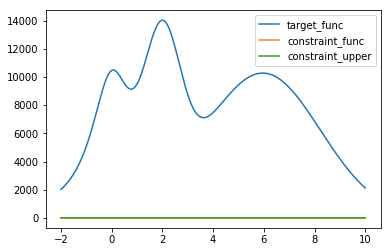

In [6]:
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)


c = constraint_func(x)
constraint_upper = 0.9

plt.plot(x, y, label='target_func')
plt.plot(x, c, label='constraint_func')
plt.plot(x, [constraint_upper]*len(x), label='constraint_upper')
plt.legend()

## Training data

In [7]:
X_train = np.array([[0], [4], [8]]) 
Y_train = np.array(list(map(target, list(X_train.reshape(1,-1).squeeze())))) # target function
C_train = constraint_func(X_train.reshape(1,-1).squeeze()) # constraint function

xi =1e-4 # parameter that controls exploit vs exploration
acq = 'ei' # acquisition function
n_iter=8 # number of iteration
SEED = 6 # random seed

## Original implementation of EI

In [8]:
gp_params = {"alpha": 1e-5, "n_restarts_optimizer": 25, "kernel": Matern(nu=2.5), "random_state": SEED}
bo = BayesianOptimization(target, {'x': (-2, 10)})

In [9]:
bo.explore({'x': list(X_train.reshape(1,-1).squeeze())})
bo.maximize(init_points=0, n_iter=n_iter, acq=acq, xi=xi,**gp_params)

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s | 10456.39361 |    0.0000 | 
    2 | 00m00s | 7474.59214 |    4.0000 | 
    3 | 00m00s | 6857.04661 |    8.0000 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    4 | 00m01s | 9914.85741 |   -0.1985 | 
    5 | 00m00s | 9260.09317 |    0.9060 | 
    6 | 00m00s | 10294.64341 |    0.2286 | 
    7 | 00m00s | 10488.97675 |    0.0537 | 
    8 | 00m00s | 2899.54195 |    9.5721 | 
    9 | 00m00s | 7540.15627 |    4.0382 | 
   10 | 00m00s | 9994.39075 |    5.4159 | 
   11 | 00m00s | 5791.70706 |   -0.8686 | 


### Visualization

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


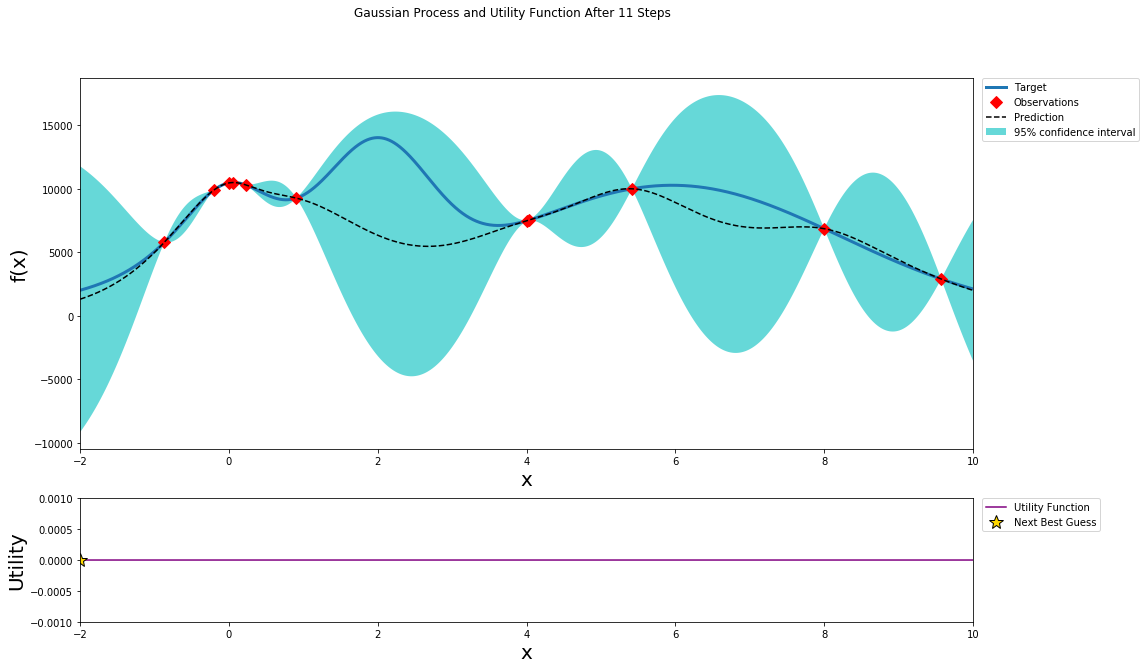

In [10]:
plot_gp(bo.gp, x, y, bo.util)

## Our implementation of EI

In [ ]:
candidates = []
# make a copy of trainning data
X_train_ = X_train
Y_train_ = Y_train
for i in range(n_iter):
    candidate = bayesian_optimizer.get_candidate(X_train_, Y_train_, [(-2, 10)], acq=acq, xi=xi, gp_params=gp_params)
    X_train_ = np.vstack((X_train_, np.array([candidate])))
    Y_train_ = np.hstack((Y_train_, target(candidate)))
    candidates.append(candidate[0])

print(f"candidates history\n{np.array(candidates)}")

### 1. Compare the result with 'bayes_opt' library

In [ ]:
assert np.allclose(bo.X, X_train_), f'origin: {bo.X}\nimpl: {X_train_}'

###  2. Behaivor of using CEI acquisition
Now we've validated that the EI implementation is identical with the orignal one, let's take s look at the result using **constrained** EI. 

In [ ]:
candidates = [] 
X_train_ = X_train
Y_train_ = Y_train
C_train_ = C_train
for i in range(n_iter):
    candidate = bayesian_optimizer.get_candidate(X_train_, Y_train_, [(-2, 10)], acq='cei', xi=xi,
                                                constraint_arr=C_train_, constraint_upper=constraint_upper, **gp_params)
    X_train_ = np.vstack((X_train_, np.array([candidate])))
    Y_train_ = np.hstack((Y_train_, target(candidate)))
    C_train_ = np.hstack((C_train_, constraint_func(candidate)))
    candidates.append(candidate[0])

print('candidates:')
print(np.array(candidates))
print('targets_function:')
print(Y_train_)
print('constraint_function:')
print(C_train_)

In [ ]:
# target function
gp = GaussianProcessRegressor()
gp.set_params(**gp_params)
gp.fit(X_train_, Y_train_)

# constrained function
gp2 = GaussianProcessRegressor()
gp2.set_params(**gp_params)
gp2.fit(X_train_, C_train_)

# utility function
util_ei = bayesian_optimizer.UtilityFunction(gp_objective=gp, kind='ei', xi=xi)
util_cei = bayesian_optimizer.UtilityFunction(gp_objective=gp, gp_constraint=gp2, 
                                          constraint_upper=constraint_upper, kind='cei', xi=xi)

plot_gps(gp, gp2, x, y, c, util_ei, util_cei, constraint_upper)

### 3. Change the upper bound of constrint
From the plot above(bottom one), we can observe that the utility of EI shows different behavior to the CEI utiliy. By choosing cei acquisition as the strategy, the optimizer tends to search for the area where it thinks the constraint will be staisfied. Let's change the upper bound, so that the maximum point for target doesn't satisfy the constraint. 

In [ ]:
constraint_upper = 0.6

In [ ]:
candidates = [] 
X_train_ = X_train
Y_train_ = Y_train
C_train_ = C_train
for i in range(n_iter):
    candidate = bayesian_optimizer.get_candidate(X_train_, Y_train_, [(-2, 10)], acq='cei', xi=xi,
                                                constraint_arr=C_train_, constraint_upper=constraint_upper, **gp_params)
    X_train_ = np.vstack((X_train_, np.array([candidate])))
    Y_train_ = np.hstack((Y_train_, target(candidate)))
    C_train_ = np.hstack((C_train_, constraint_func(candidate)))
    candidates.append(candidate[0])

print('candidates:')
print(np.array(candidates))
print('target_function:')
print(Y_train_)
print('constraint_function:')
print(C_train_)

### Visualization

In [ ]:
# target function
gp = GaussianProcessRegressor()
gp.set_params(**gp_params)
gp.fit(X_train_, Y_train_)

# constrained function
gp2 = GaussianProcessRegressor()
gp2.set_params(**gp_params)
gp2.fit(X_train_, C_train_)

# utility function
util_ei = bayesian_optimizer.UtilityFunction(gp_objective=gp, kind='ei', xi=xi)
util_cei = bayesian_optimizer.UtilityFunction(gp_objective=gp, gp_constraint=gp2, 
                                          constraint_upper=constraint_upper, kind='cei', xi=xi)

plot_gps(gp, gp2, x, y, c, util_ei, util_cei, constraint_upper)

We can see that the algorithm search for the region on the right (i.e. satisfy the constraint) as soons as it find out the left region doesn't satisfy the constraint.